In [1]:
try: 
    import pykalman
except Exception:
    !pip install pystan
    !pip install pykalman
finally:
    import pykalman

# Naive Exploration

This initial section plots yield of crops against years and scales yield to a 0-1 range so that yield values can be compared

In [2]:
%matplotlib inline
import numpy as np
from plotly import express as px
import pandas as pd
from sklearn import preprocessing
from plotly import graph_objects as go
from plotly import express as px
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3 import *

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Area 220 is for Trinidad

df = dict()
# MinMax scaler used since historically, Trinidad's citrus output was overall higer 
scaler = preprocessing.MinMaxScaler()

def read_and_plot(csvname, areacode):
    temp_csv = pd.read_csv(csvname)
    temp_csv = temp_csv[temp_csv['Area Code'] == areacode]
    temp_csv.columns = ['area-code', 'year', 'val']
    # Trend removal by differencing
    temp_csv.val = temp_csv.val.diff()
    # Scaling
    temp_csv.val = scaler.fit_transform(np.array(temp_csv.val).reshape(-1, 1))
    # Removing data before 1980
    temp_csv = temp_csv[temp_csv.year >= 1980]
    fig=go.Figure()
    fig = px.scatter(temp_csv,x='year', y='val')
    plot_title = csvname.split('.')[0]
    fig.update_layout(
      title=f"{plot_title}")
    fig.show()
    return temp_csv

pigeon_peas = read_and_plot('PigeonPeas.csv', 220)

In [3]:
sweet_potato = read_and_plot('SweetPotatoes.csv', 220)

In [4]:
citrus = read_and_plot('citrus.csv', 220)

## Cleaning Weather Data

In [5]:
weather_df = pd.read_csv('weather-data.csv')
weather_df.head()

dt                         dt_iso  timezone            city_name  \
0  315532800  1980-01-01 00:00:00 +0000 UTC    -14400  Trinidad and Tobago   
1  315536400  1980-01-01 01:00:00 +0000 UTC    -14400  Trinidad and Tobago   
2  315540000  1980-01-01 02:00:00 +0000 UTC    -14400  Trinidad and Tobago   
3  315543600  1980-01-01 03:00:00 +0000 UTC    -14400  Trinidad and Tobago   
4  315547200  1980-01-01 04:00:00 +0000 UTC    -14400  Trinidad and Tobago   

         lat        lon    temp  feels_like  temp_min  temp_max  ...  \
0  10.691803 -61.222503  298.48      299.18   297.800   298.890  ...   
1  10.691803 -61.222503  298.46      299.38   297.798   298.903  ...   
2  10.691803 -61.222503  298.32      301.06   297.706   298.931  ...   
3  10.691803 -61.222503  298.28      301.00   297.660   298.933  ...   
4  10.691803 -61.222503  298.33      301.08   297.722   299.000  ...   

   wind_deg  rain_1h  rain_3h  snow_1h  snow_3h  clouds_all  weather_id  \
0        96     0.14      NaN      NaN      NaN          18         500   
1        95     0.14      NaN      NaN      NaN          24         500   
2        90      NaN      NaN      NaN      NaN          20         801   
3        90      NaN      NaN      NaN      NaN          20         801   
4        90      NaN      NaN      NaN      NaN          20         801   

   weather_main  weather_description  weather_icon  
0          Rain           light rain           10n  
1          Rain           light rain           10n  
2        Clouds           few clouds           02n  
3        Clouds           few clouds           02n  
4        Clouds           few clouds           02n  

[5 rows x 25 columns]

Dropping non-necessary columns

In [6]:
cols = [
  'dt', # Unix timestamp
  'timezone', # data is for Trinidad
  'city_name',
  'lat',
  'lon',
  'feels_like', # does not affect crops
  'sea_level', 
  'grnd_level',
  'snow_1h', # not applicable
  'snow_3h',
  'weather_id', # id for next column of general conditions
  'weather_icon', 
  'weather_description'
]

weather_df.drop(cols, axis=1, inplace=True)

Checking for null values, and exploring

In [7]:
weather_df.isna().sum()

dt_iso               0
temp                 0
temp_min             0
temp_max             0
pressure             0
humidity             0
wind_speed           0
wind_deg             0
rain_1h         315115
rain_3h         363199
clouds_all           0
weather_main         0
dtype: int64

In [8]:
weather_df[weather_df['rain_1h'].isna()].sample(15)

dt_iso    temp  temp_min  temp_max  pressure  \
361110  2020-10-06 21:00:00 +0000 UTC  302.05   300.111   303.710      1010   
78324   1988-08-27 03:00:00 +0000 UTC  298.19   297.250   299.450      1011   
207742  2003-05-11 17:00:00 +0000 UTC  304.23   300.421   306.150      1014   
107951  1992-01-11 10:00:00 +0000 UTC  295.90   294.450   297.733      1012   
323686  2016-07-08 16:00:00 +0000 UTC  305.11   300.886   307.150      1016   
100461  1991-03-06 01:00:00 +0000 UTC  298.47   297.597   299.150      1013   
312022  2015-03-11 03:00:00 +0000 UTC  298.01   297.450   298.150      1015   
89500   1989-12-04 14:00:00 +0000 UTC  299.77   299.616   299.981      1014   
339926  2018-05-14 05:00:00 +0000 UTC  298.41   297.906   299.150      1013   
288522  2012-07-08 10:00:00 +0000 UTC  298.46   298.110   299.408      1013   
17176   1981-10-27 20:00:00 +0000 UTC  301.27   299.816   302.150      1011   
57517   1986-04-15 13:00:00 +0000 UTC  299.61   298.762   301.350      1013   
207079  2003-04-14 04:00:00 +0000 UTC  299.24   298.369   300.150      1017   
206134  2003-03-05 20:00:00 +0000 UTC  302.18   299.002   304.150      1013   
9135    1980-12-27 01:00:00 +0000 UTC  297.97   297.114   298.454      1012   

        humidity  wind_speed  wind_deg  rain_1h  rain_3h  clouds_all  \
361110        62        1.50       290      NaN      NaN          20   
78324         91        3.97        82      NaN      NaN          40   
207742        52        8.20        70      NaN      NaN          40   
107951        95        6.21        71      NaN      NaN          96   
323686        56        7.20        90      NaN      NaN          40   
100461        80        3.10        70      NaN      NaN          40   
312022        78        3.10       100      NaN      NaN          20   
89500         70        5.82        88      NaN      NaN          38   
339926        94        3.10       110      NaN      NaN          40   
288522        83        4.87        95      NaN      NaN          40   
17176         70        4.60       100      NaN      NaN          40   
57517         72        6.70       100      NaN      NaN          75   
207079        88        3.10        80      NaN      NaN          75   
206134        55        7.20        70      NaN      NaN          20   
9135          86        4.46        65      NaN      NaN          35   

       weather_main  
361110       Clouds  
78324          Haze  
207742       Clouds  
107951       Clouds  
323686       Clouds  
100461         Haze  
312022       Clouds  
89500        Clouds  
339926       Clouds  
288522       Clouds  
17176        Clouds  
57517          Haze  
207079       Clouds  
206134       Clouds  
9135         Clouds

In [9]:
weather_df[weather_df['rain_3h'].isna()].sample(15)

dt_iso    temp  temp_min  temp_max  pressure  \
151109  1996-12-07 03:00:00 +0000 UTC  297.82   296.690   298.150      1013   
252498  2008-06-08 16:00:00 +0000 UTC  302.57   299.725   304.150      1014   
78346   1988-08-28 01:00:00 +0000 UTC  299.64   298.788   301.150      1011   
57872   1986-04-29 18:00:00 +0000 UTC  303.43   300.164   305.250      1012   
263024  2009-08-17 22:00:00 +0000 UTC  301.95   300.982   303.150      1010   
61845   1986-10-11 07:00:00 +0000 UTC  297.42   297.017   297.638      1008   
190511  2001-05-27 02:00:00 +0000 UTC  299.15   299.042   299.390      1014   
249704  2008-02-13 08:00:00 +0000 UTC  296.24   296.107   296.541      1013   
4531    1980-06-26 19:00:00 +0000 UTC  301.33   299.470   302.150      1015   
265851  2009-12-13 03:00:00 +0000 UTC  297.75   296.950   299.111      1014   
144030  1996-02-18 13:00:00 +0000 UTC  300.41   298.806   302.150      1013   
271056  2010-07-16 00:00:00 +0000 UTC  299.63   298.731   300.150      1011   
289219  2012-08-06 07:00:00 +0000 UTC  298.06   297.691   298.150      1012   
87973   1989-10-01 23:00:00 +0000 UTC  299.47   299.436   299.555      1012   
229246  2005-10-17 22:00:00 +0000 UTC  301.08   300.837   301.150      1010   

        humidity  wind_speed  wind_deg  rain_1h  rain_3h  clouds_all  \
151109        94        2.10        80      NaN      NaN          20   
252498        74        5.70        90      NaN      NaN          40   
78346         94        2.60        90      NaN      NaN          40   
57872         54        7.70       120      NaN      NaN          20   
263024        70        3.60        80      NaN      NaN          20   
61845         93        7.87        81      NaN      NaN          40   
190511        88        4.60        60     0.13      NaN          75   
249704        94        1.50        70      NaN      NaN          75   
4531          79        7.20        90      NaN      NaN          40   
265851        89        7.33        74      NaN      NaN          20   
144030        69        5.70        80      NaN      NaN          20   
271056        87        3.75        83      NaN      NaN          75   
289219       100        4.87        84      NaN      NaN          40   
87973         85        3.84        94      NaN      NaN          69   
229246        78        3.60        80      NaN      NaN          75   

       weather_main  
151109       Clouds  
252498       Clouds  
78346        Clouds  
57872          Dust  
263024       Clouds  
61845        Clouds  
190511         Rain  
249704       Clouds  
4531         Clouds  
265851         Mist  
144030       Clouds  
271056         Haze  
289219       Clouds  
87973        Clouds  
229246       Clouds

In [10]:
cols_to_difference = [
    'temp',
    'temp_min',
    'temp_max',
    'pressure',
    'humidity',
    'wind_speed',
    'wind_deg',
    'rain_1h',
    'rain_3h',
    'clouds_all',
]

weather_df[cols_to_difference] = weather_df[cols_to_difference].diff()

## Data Averaging

Data will be averaged across weeks (since crop yield data is not at such a level of granularity). Hence NaN values will be averaged out, according to climate.gov, this is a valid method

In [18]:
year_range = range(1981, 2020, 1)


year_vals = dict()
month_vals = dict()
month_weather_df = pd.DataFrame(columns=['year', 'month', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean', 'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'])

for year in year_range:
    year_df = weather_df.copy()
    year_df = year_df[year_df['dt_iso'] < f'{year+1}-01-01 00:00:00 +0000 UTC']
    year_df = year_df[year_df['dt_iso'] >= f'{year}-01-01 00:00:00 +0000 UTC' ]
    for month in range(1,13, 1):
        month_df = year_df.copy()
        month_df = month_df[month_df['dt_iso'] < f'{year+1}-0{month+1}-01 00:00:00 +0000 UTC']
        month_df = month_df[month_df['dt_iso'] >= f'{year}-0{month}-01 00:00:00 +0000 UTC' ]
        month_vals = dict({
          'year': int(year),
          'month': int(month),
          'temp_max' : month_df.temp_max.mean(),
          'temp_min' : month_df.temp_min.mean(),
          'temp' : month_df.temp.mean(),
          'pressure_var': month_df.pressure.var(),
          'pressure_mean': month_df.pressure.mean(),
          'humidity_mean': month_df.humidity.mean(),
          'humidity_var': month_df.humidity.var(),
          'rain_mean': month_df.rain_1h.mean(),
          'rain_var': month_df.rain_1h.var()
        })
        
        month_weather_df = month_weather_df.append(month_vals, ignore_index=True)


month_weather_df.year = month_weather_df.year.astype(int)
month_weather_df.month = month_weather_df.month.astype(int)
month_weather_df.set_index(['month', 'year'], inplace=True)

month_weather_df.head()
month_weather_df.to_json('month_weather.json')

In [19]:
year_range = range(1980, 2020, 1)


year_vals = dict()
year_weather_df = pd.DataFrame(columns=['year', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean', 'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'])

for year in year_range:
    year_df = weather_df.copy()
    year_df = year_df[year_df['dt_iso'] < f'{year+1}-01-01 00:00:00 +0000 UTC']
    year_df = year_df[year_df['dt_iso'] >= f'{year}-01-01 00:00:00 +0000 UTC' ]
    year_vals[year] = dict({
      'year': int(year),
      'temp_max' : year_df.temp_max.mean(),
      'temp_min' : year_df.temp_min.mean(),
      'temp' : year_df.temp.mean(),
      'pressure_var': year_df.pressure.var(),
      'pressure_mean': year_df.pressure.mean(),
      'humidity_mean': year_df.humidity.mean(),
      'humidity_var': year_df.humidity.var(),
      'rain_mean': year_df.rain_1h.mean(),
      'rain_var': year_df.rain_1h.var()
    })

    year_weather_df = year_weather_df.append(year_vals[year], ignore_index=True)

year_weather_df.year = year_weather_df.year.astype(int)

Scale weather after differencing and save scaler for future use

In [20]:
from pickle import dump
from sklearn.preprocessing import MinMaxScaler

weather_scaler = MinMaxScaler()

cols_to_scale = ['temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean', 'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var']
weather_scaler.fit(year_weather_df[cols_to_scale])
year_weather_df[cols_to_scale] = weather_scaler.transform(year_weather_df[cols_to_scale])

dump(weather_scaler, open('weather_scaler.pkl', 'wb'))

In [21]:
def plot_weather(weather):
    fig = go.Figure()
    for param in weather:
        fig.add_trace(
            go.Scatter(x=year_weather_df.year, y=year_weather_df[param], name=str(param))
        )
        fig.update_layout(
          xaxis_title='Year',
          title=f'Weather Parameters: {[w for w in weather]}'
        )
    fig.show()

In [22]:
plot_weather(['rain_var', 'rain_mean'])

In [23]:
plot_weather(['pressure_var', 'pressure_mean'])

In [24]:
plot_weather(['humidity_var', 'humidity_mean'])

In [25]:
def plot_against(p1, p2, title='', p1_name='', p2_name=''):
    fig = px.scatter(x=p1, y=p2, title=title, trendline='ols')
    fig.update_layout(
      xaxis_title=p1_name,
      yaxis_title=p2_name
    )
    return fig

In [26]:
year_weather_df.columns

Index(['year', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean',
       'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'],
      dtype='object')

## Plotting Yield Against Weather

The crop yield for all crops are plotted against all weather features to get a general idea of correlation

In [27]:
from plotly.subplots import make_subplots
def plot_against_all(crop, title=''):
    fig = make_subplots(rows=3, cols=3,
                      subplot_titles=("Min Temp","Mean Pressure", "Variance in Pressure", 'Max Temp', 'Mean Humidity', 'Variance in Humidity', 'Temp', 'Mean Rain', 'Variance in Rain'))
    # Temperatures
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.temp_min), y=np.asarray(crop.val), mode='markers', name='Min Temp'), col=1, row=1
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.temp_max), y=np.asarray(crop.val), mode='markers'), col=1, row=2
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.temp), y=np.asarray(crop.val), mode='markers'), col=1, row=3
    )

    # Pressure
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.pressure_mean), y=np.asarray(crop.val), mode='markers'), col=2, row=1
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.pressure_var), y=np.asarray(crop.val), mode='markers'), col=3, row=1
    )

    # Humidity
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.humidity_mean), y=np.asarray(crop.val), mode='markers'), col=2, row=2
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.humidity_var), y=np.asarray(crop.val), mode='markers'), col=2, row=3
    )

    # Rain
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.rain_mean), y=np.asarray(crop.val), mode='markers'), col=3, row=2
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.rain_var), y=np.asarray(crop.val), mode='markers'), col=3, row=3
    )
    fig.update_layout(
      showlegend=False, 
      title=f'Crop Yield for {title} against Weather',
      autosize=False,
      width=1200,
      height=1200
    )

    fig.update_xaxes(type='log')
    return fig


In [28]:
plot_against_all(pigeon_peas, title='Pigeon Peas')

In [29]:
plot_against_all(citrus, title='Citrus')

In [30]:
plot_against_all(sweet_potato, title='Sweet Potatoe')

# Exploration for Correlation using Spearman and Pearson

The following finds the pearsonr and spearman correlation coefficients for all the crops against the weather variables, instead of attempting to fit a model against all weather features, we first look for weather features that already show statistical correlation and build transformations around these features

## Pigeon Peas

From the result below, **temp_min (exp), temp_min(None), and temp_max(log)** would be explored owing to their p-values

In [31]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr


weather_features = [str(f) for f in year_weather_df.columns[1:]]

def calculate_correlation(crop_df):
    vals = pd.DataFrame(columns=['transform', 'feature', 'pearsonr', 'p1', 'spearmanr', 'p2', 'cov'])
    TRANSFORM = None
    crop_val = crop_df.val.values
    for f in weather_features:
        weather_feature = year_weather_df[f].values
        spearman = spearmanr(np.array(weather_feature), crop_df.val.values)
        pearson = pearsonr(np.array(weather_feature), crop_df.val.values)
        covariance = np.cov(np.hstack([weather_feature, crop_df.val.values]))
        vals = vals.append({'transform': TRANSFORM, 'feature':f, 'pearsonr': pearson[0], 'p1': pearson[1], 'spearmanr': spearman[0], 'p2': spearman[1], 'cov':covariance}, ignore_index=True)
    
    TRANSFORM = 'log'
#     for f in weather_features:
#         print(f)
#         weather_feature = np.log(year_weather_df[f].values)
#         spearman = spearmanr(weather_feature, crop_df.val.values)
#         pearson = pearsonr(weather_feature, crop_df.val.values)[0]
#         covariance = np.cov(np.hstack([weather_feature, crop_df.val.values]))
#         vals = vals.append({'transform': TRANSFORM, 'feature':f, 'pearsonr': pearson, 'spearmanr': spearman[0], 'p': spearman[1], 'cov': covariance}, ignore_index=True)
    
    TRANSFORM = 'exp'
    for f in weather_features:
        weather_feature = np.exp(year_weather_df[f].values, dtype=np.float128)
        spearman = spearmanr(weather_feature, crop_df.val.values)
        pearson = pearsonr(weather_feature, crop_df.val.values)
        vals = vals.append({'transform': TRANSFORM, 'feature':f, 'pearsonr': pearson[0], 'p1': pearson[1], 'spearmanr': spearman[0], 'p2': spearman[1], 'cov': covariance}, ignore_index=True)
 
    return vals.sort_values(['p1', 'p2'])


calculate_correlation(pigeon_peas)

transform        feature  pearsonr        p1  spearmanr        p2  \
9        exp       temp_min -0.251880  0.116901  -0.244653  0.128139   
0       None       temp_min -0.236348  0.142025  -0.244653  0.128139   
1       None       temp_max  0.186259  0.249834   0.138345  0.394585   
6       None   humidity_var  0.174431  0.281707   0.160600  0.322192   
15       exp   humidity_var  0.173729  0.283676   0.160600  0.322192   
10       exp       temp_max  0.151980  0.349182   0.138345  0.394585   
5       None  humidity_mean -0.128702  0.428671  -0.048126  0.768074   
16       exp      rain_mean  0.125994  0.438526   0.098874  0.543853   
7       None      rain_mean  0.112726  0.488596   0.098874  0.543853   
14       exp  humidity_mean -0.107401  0.509487  -0.048126  0.768074   
17       exp       rain_var  0.074332  0.648504   0.080863  0.619881   
8       None       rain_var  0.074270  0.648776   0.080863  0.619881   
4       None  pressure_mean  0.066441  0.683761   0.097470  0.549616   
13       exp  pressure_mean  0.047620  0.770447   0.097470  0.549616   
11       exp           temp -0.020964  0.897833  -0.038274  0.814616   
12       exp   pressure_var -0.003755  0.981654  -0.042402  0.795031   
3       None   pressure_var -0.003094  0.984885  -0.042402  0.795031   
2       None           temp -0.002071  0.989881  -0.038274  0.814616   

                    cov  
9   0.06526484708137437  
0   0.04391437824063992  
1   0.05860573476949709  
6   0.05769483280779591  
15  0.06526484708137437  
10  0.06526484708137437  
5   0.05678841820539136  
16  0.06526484708137437  
7   0.05468875744552527  
14  0.06526484708137437  
17  0.06526484708137437  
8   0.06526484708137437  
4   0.06324376160146988  
13  0.06526484708137437  
11  0.06526484708137437  
12  0.06526484708137437  
3   0.09667431055752343  
2   0.05355149545232404

## Citrus

From the results below **rain_mean (exp), pressure_mean(None) and rain_var(None)** will be explored owing to their p-values

In [32]:
calculate_correlation(citrus)

transform        feature  pearsonr        p1  spearmanr        p2  \
16       exp      rain_mean -0.259478  0.105905  -0.094184  0.563217   
4       None  pressure_mean  0.250307  0.119282   0.188664  0.243660   
7       None      rain_mean -0.219452  0.173647  -0.094184  0.563217   
13       exp  pressure_mean  0.202514  0.210122   0.188664  0.243660   
9        exp       temp_min -0.133559  0.411302  -0.091932  0.572624   
0       None       temp_min -0.120886  0.457461  -0.091932  0.572624   
5       None  humidity_mean -0.065362  0.688639  -0.202261  0.210704   
14       exp  humidity_mean -0.064335  0.693287  -0.202261  0.210704   
8       None       rain_var -0.032139  0.843930  -0.278612  0.081705   
1       None       temp_max  0.026828  0.869474  -0.013046  0.936318   
6       None   humidity_var -0.022192  0.891885   0.230019  0.153331   
11       exp           temp -0.015246  0.925609   0.058537  0.719755   
2       None           temp -0.014607  0.928717   0.058537  0.719755   
17       exp       rain_var  0.014192  0.930736  -0.278612  0.081705   
12       exp   pressure_var -0.011907  0.941871   0.122702  0.450680   
3       None   pressure_var -0.011765  0.942563   0.122702  0.450680   
10       exp       temp_max  0.006063  0.970383  -0.013046  0.936318   
15       exp   humidity_var  0.000491  0.997600   0.230019  0.153331   

                     cov  
16   0.03739526246546382  
4     0.0404921766179392  
7   0.034676213242960455  
13   0.03739526246546382  
9    0.03739526246546382  
0    0.02072604696598088  
5      0.035179619922625  
14   0.03739526246546382  
8    0.03739526246546382  
1   0.037800255531344036  
6   0.042338947415077675  
11   0.03739526246546382  
2   0.029800380212532743  
17   0.03739526246546382  
12   0.03739526246546382  
3    0.06218919848615583  
10   0.03739526246546382  
15   0.03739526246546382

## Sweet Potato

From the results below, **pressure_mean (exp), temp_max (exp)** will be explored owing to their p-values

In [33]:
calculate_correlation(sweet_potato)

transform        feature  pearsonr        p1  spearmanr        p2  \
4       None  pressure_mean -0.274919  0.086005  -0.263122  0.100920   
13       exp  pressure_mean -0.229671  0.153971  -0.263122  0.100920   
6       None   humidity_var  0.134193  0.409064  -0.258912  0.106697   
14       exp  humidity_mean -0.106678  0.512358   0.096721  0.552702   
16       exp      rain_mean -0.096452  0.553812  -0.166229  0.305297   
7       None      rain_mean -0.091935  0.572612  -0.166229  0.305297   
5       None  humidity_mean -0.089328  0.583592   0.096721  0.552702   
10       exp       temp_max -0.086568  0.595321   0.031067  0.849075   
1       None       temp_max -0.071246  0.662207   0.031067  0.849075   
15       exp   humidity_var  0.060506  0.710729  -0.258912  0.106697   
8       None       rain_var -0.058779  0.718643  -0.129268  0.426623   
0       None       temp_min -0.041627  0.798695  -0.047842  0.769404   
17       exp       rain_var -0.041047  0.801446  -0.129268  0.426623   
11       exp           temp  0.012253  0.940184  -0.006754  0.967006   
2       None           temp -0.007317  0.964258  -0.006754  0.967006   
3       None   pressure_var -0.002090  0.989789  -0.180675  0.264564   
9        exp       temp_min -0.002037  0.990045  -0.047842  0.769404   
12       exp   pressure_var -0.001390  0.993206  -0.180675  0.264564   

                     cov  
4   0.051107699410462566  
13   0.06475402009755156  
6   0.028759873891410354  
14   0.06475402009755156  
16   0.06475402009755156  
7     0.0363311251865279  
5    0.04205658322378502  
10   0.06475402009755156  
1    0.04204920781625454  
15   0.06475402009755156  
8    0.06475402009755156  
0    0.03277035956759427  
17   0.06475402009755156  
11   0.06475402009755156  
2   0.043685807462247185  
3    0.11119026517069605  
9    0.06475402009755156  
12   0.06475402009755156

# GLM Modeling
## Sweet Potato

In [34]:
year_weather_df.columns

Index(['year', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean',
       'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'],
      dtype='object')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 34900
Interrupted at 34,899 [17%]: Average Loss = 168.97
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, np.exp(temp_max), np.exp(pressure_mean), Intercept]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 59 seconds.


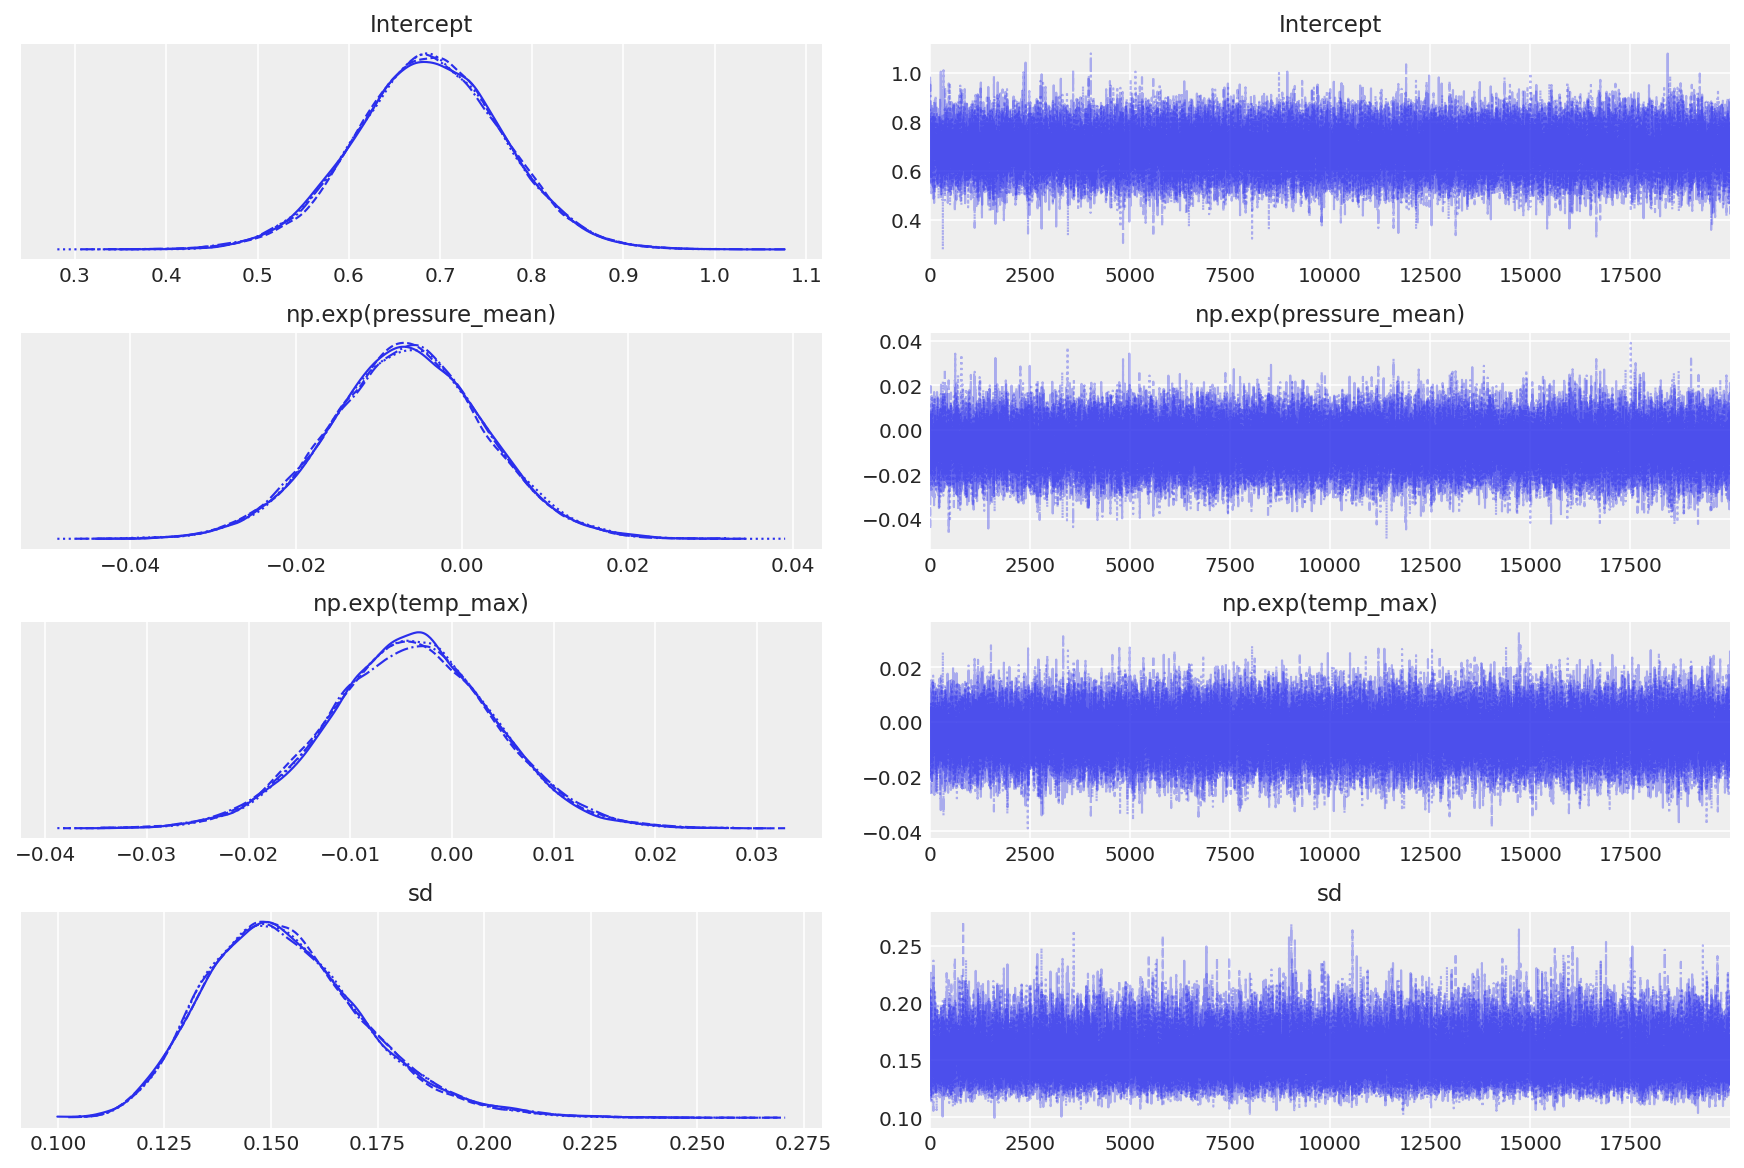

In [35]:
spotato_weather = pd.merge(left=year_weather_df, right=sweet_potato, left_on='year', right_on='year')
spotato_weather = spotato_weather.drop(['area-code', 'year'], axis=1)
spotato_weather = spotato_weather[['humidity_mean', 'temp_max', 'val']]


spotato_weather['pressure_mean'] = np.exp(spotato_weather['humidity_mean'])
spotato_weather['temp_max'] = np.exp(spotato_weather['temp_max'])


formula = 'val ~ np.exp(pressure_mean) + np.exp(temp_max)'
## pressure_mean (exp), temp_max (exp)


with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula(formula, spotato_weather)
    idata = pm.sample(20000, init='advi+adapt_diag', progressbar = True, tune = 10000, return_inferencedata=True)
    az.plot_trace(idata)

## Citrus

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18300
Interrupted at 18,299 [9%]: Average Loss = 75.326
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, rain_var, pressure_mean, rain_mean, Intercept]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 120 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
There were 428 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


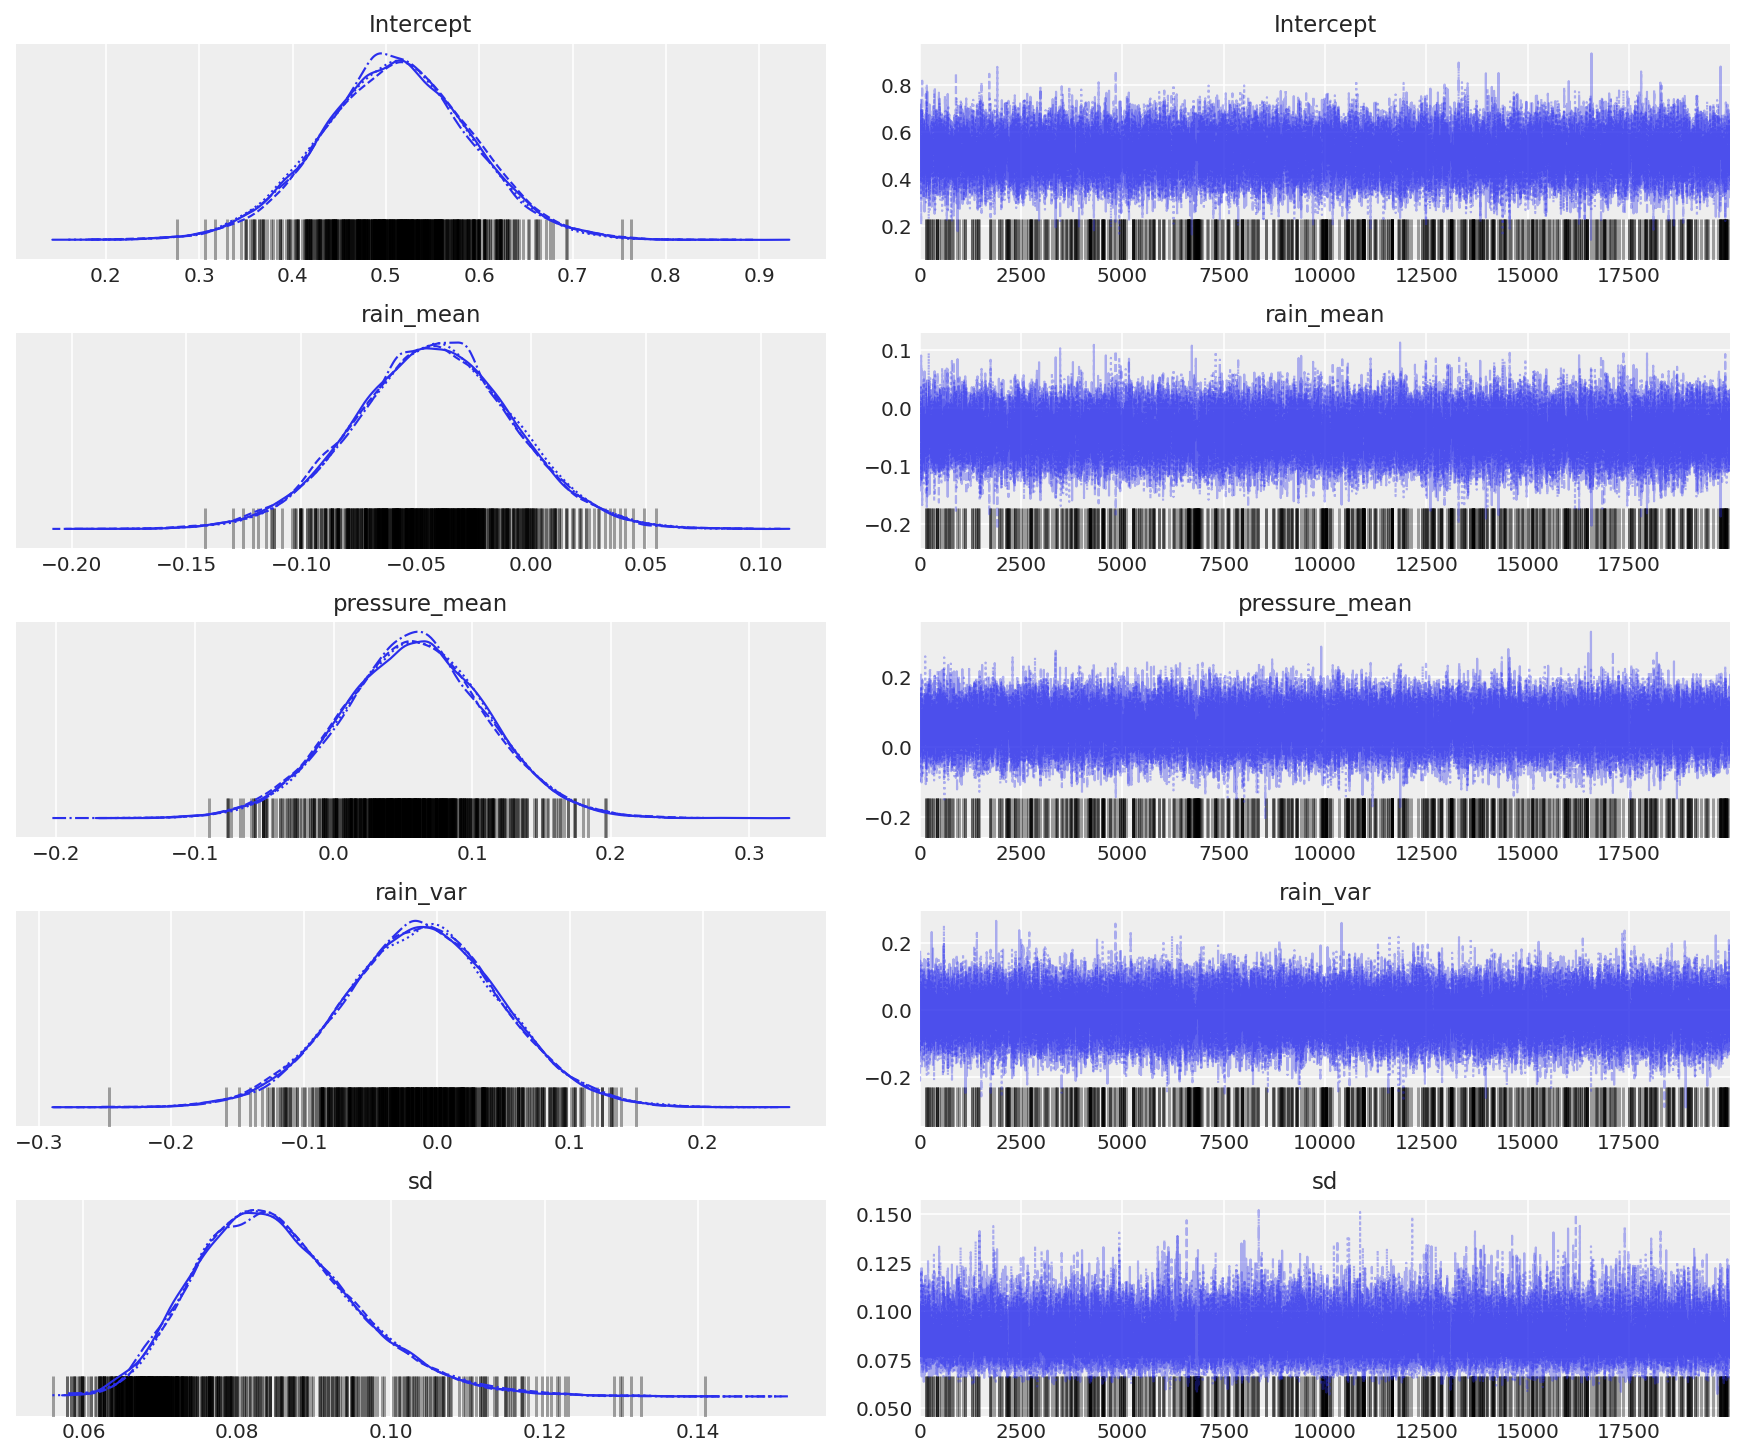

In [36]:
## rain_mean (exp), pressure_mean(None) and rain_var(None)
# Context for the model

citrus_weather = pd.merge(left=year_weather_df, right=citrus, left_on='year', right_on='year')
citrus_weather = citrus_weather.drop(['area-code', 'year'], axis=1)
citrus_weather = citrus_weather[['pressure_mean', 'rain_mean', 'rain_var', 'val']]

citrus_weather['rain_mean'] = np.exp(citrus_weather['rain_mean'])

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula("val ~ rain_mean + pressure_mean + rain_var", citrus_weather)
    idata = pm.sample(20000, init='advi+adapt_diag', progressbar = True, tune = 10000, return_inferencedata=True)
    az.plot_trace(idata)

## Pigeon Peas

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 13300
Interrupted at 13,299 [6%]: Average Loss = 73.993
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, temp_max, temp_min, Intercept]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 134 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


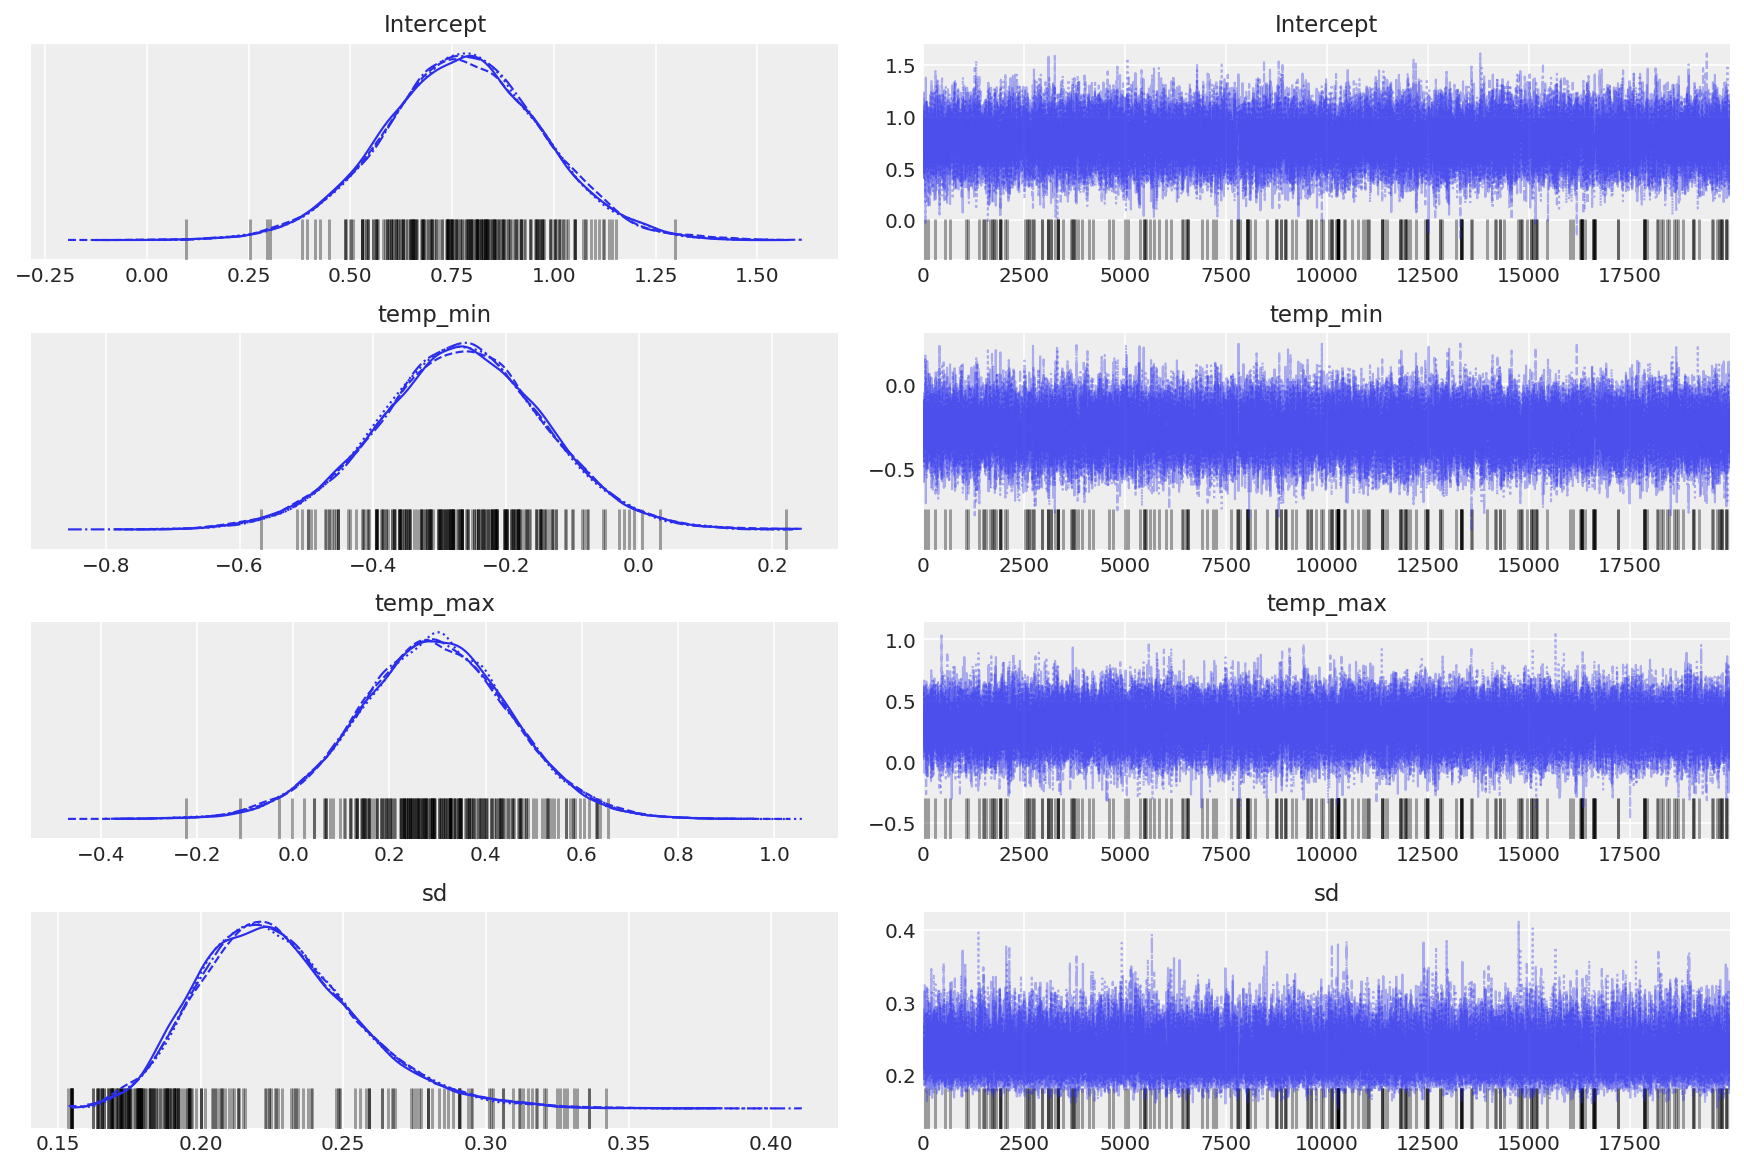

In [37]:
## temp_min (exp), temp_min(None), and temp_max (None)
# Context for the model

peas_weather = pd.merge(left=year_weather_df, right=pigeon_peas, left_on='year', right_on='year')
peas_weather = peas_weather.drop(['area-code', 'year'], axis=1)
peas_weather = peas_weather[['temp_min', 'temp_max', 'val']]


peas_weather['temp_min'] = np.exp(peas_weather['temp_min'])

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula("val ~ temp_min + temp_max", peas_weather)
    idata = pm.sample(20000, init='advi+adapt_diag', progressbar = True, tune = 10000, return_inferencedata=True)
    az.plot_trace(idata)

# Standard Regression
## Sweet Potato

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
clf = LinearRegression()

# pressure_mean (exp), temp_max (exp)

X_potato, y_potato = spotato_weather[['pressure_mean', 'temp_max']], spotato_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_potato, y_potato, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')


Coefficients: [-0.0055308  0.0083477], Intercept: 0.6374560226708211


## Citrus

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
clf = LinearRegression()

#  rain_mean (exp), pressure_mean(None) and rain_var(None)

X_citrus, y_citrus = citrus_weather[['rain_mean', 'pressure_mean', 'rain_var']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_citrus, y_citrus, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.01557557  0.03263619 -0.00763393], Intercept: 0.48086858250801057


## Pigeon Peas

In [40]:
clf = LinearRegression()

## temp_min (exp), temp_min(None), and temp_max (None)

X_peas, y_peas = peas_weather[['temp_min', 'temp_max']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_peas, y_peas, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.01103747  0.00742018], Intercept: 0.48056022322288927


# Bayesian Ridge Regression
## Sweet Potato

In [41]:
from sklearn.linear_model import BayesianRidge

clf = BayesianRidge()

# pressure_mean (exp), temp_max (exp)

X_potato, y_potato = spotato_weather[['pressure_mean', 'temp_max']], spotato_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_potato, y_potato, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.00014997  0.00025929], Intercept: 0.6423671170351578


## Citrus

In [42]:
clf = BayesianRidge()

#  rain_mean (exp), pressure_mean(None) and rain_var(None)

X_citrus, y_citrus = citrus_weather[['rain_mean', 'pressure_mean', 'rain_var']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_citrus, y_citrus, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.00085566  0.00086965 -0.00013873], Intercept: 0.467727533309953


## Pigeon Peas

In [43]:
clf = BayesianRidge()

## temp_min (exp), temp_min(None), and temp_max (None)

X_peas, y_peas = peas_weather[['temp_min', 'temp_max']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_peas, y_peas, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-5.04409361e-04  7.41140898e-05], Intercept: 0.46734554131456396
